In [1]:
import geopandas as gpd
import sys
sys.path.append('/home/lpsha/s154446/fractality/dual_graph_algo/')
import dual_conti

from pyrosm import OSM, get_data
import osmnx as ox
import momepy

import matplotlib.pyplot as plt

import numpy as np

# create a polygon of the bounding box
from shapely.geometry import box
from shapely.geometry import LineString
from shapely.geometry import Point

import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

from multiprocessing import Pool, cpu_count


# --- Nature-style aesthetics ---
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['figure.dpi'] = 150
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['axes.titlepad'] = 10

In [2]:
OSRM = {
    "foot": "http://localhost:5000",
    "bike": "http://localhost:5001",
    "car":  "http://localhost:5002",
}

def get_osrm_route(
    lon1, lat1,
    lon2, lat2,
    mode,
    overview="simplified",
    geometries="geojson",
):
    """
    Query OSRM and return route geometry + metadata.

    mode: one of {"foot", "bike", "car"}
    """
    if mode not in OSRM:
        raise ValueError(f"Unknown mode '{mode}'. Available: {list(OSRM)}")

    url = (
        f"{OSRM[mode]}/route/v1/{mode}/"
        f"{lon1},{lat1};{lon2},{lat2}"
    )

    params = {
        "overview": overview,
        "geometries": geometries,
    }

    r = requests.get(url, params=params)
    r.raise_for_status()

    data = r.json()
    route = data["routes"][0]
    geom = route["geometry"]

    return {
        "mode": mode,
        "geometry": LineString(geom["coordinates"]),
        "distance_m": route["distance"],
        "duration_s": route["duration"],
        "raw": data,
    }

# Copenhagen

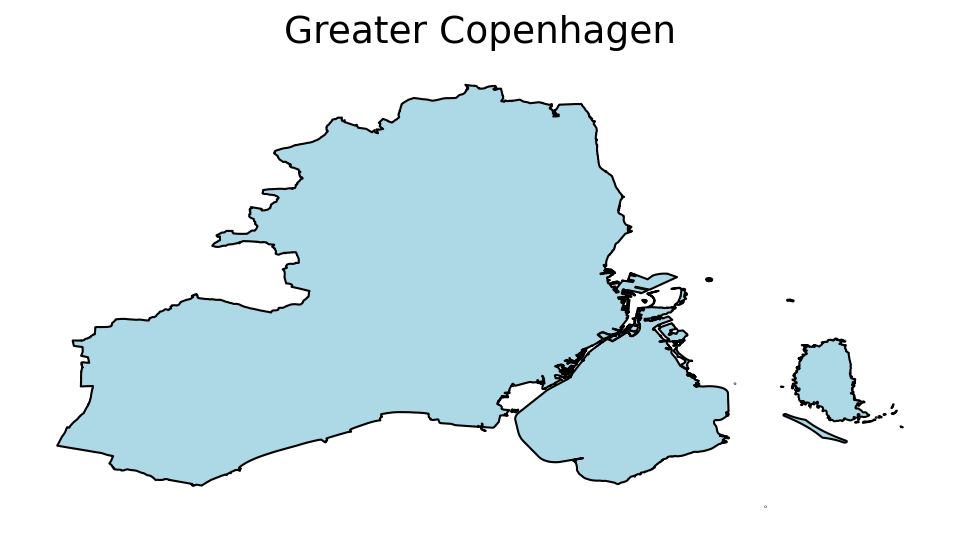

In [5]:
# List of municipalities
municipalities = [
    "Albertslund", "Ballerup", "Brøndby", "Dragør", "Frederiksberg",
    "Furesø", "Gentofte", "Gladsaxe", "Glostrup", "Greve",
    "Herlev", "Hvidovre", "Høje-Taastrup", "Ishøj", "Københavns",
    "Lyngby-Taarbæk", "Rudersdal", "Rødovre", "Tårnby", "Vallensbæk"
]

all_gdfs = []

for name in municipalities:
    try:
        # Fetch municipality polygon
        gdf = ox.geocode_to_gdf(f"{name} Kommune, Denmark")
        all_gdfs.append(gdf)
    except Exception as e:
        print(f"Failed to fetch {name}: {e}")

# Combine all GeoDataFrames
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))

# Merge into a single polygon
combined_polygon = combined_gdf.geometry.union_all()

# Plot the combined municipalities
gpd.GeoSeries([combined_polygon]).plot(figsize=(8,8), edgecolor='k', facecolor='lightblue')
plt.title("Greater Copenhagen")
plt.axis('off')
plt.show()

In [3]:
minx, miny, maxx, maxy = combined_polygon.bounds
bbox_polygon = box(minx, miny, maxx, maxy)
G = ox.graph.graph_from_polygon(bbox_polygon)

In [ ]:
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged.crs = 3857

osmnx graph


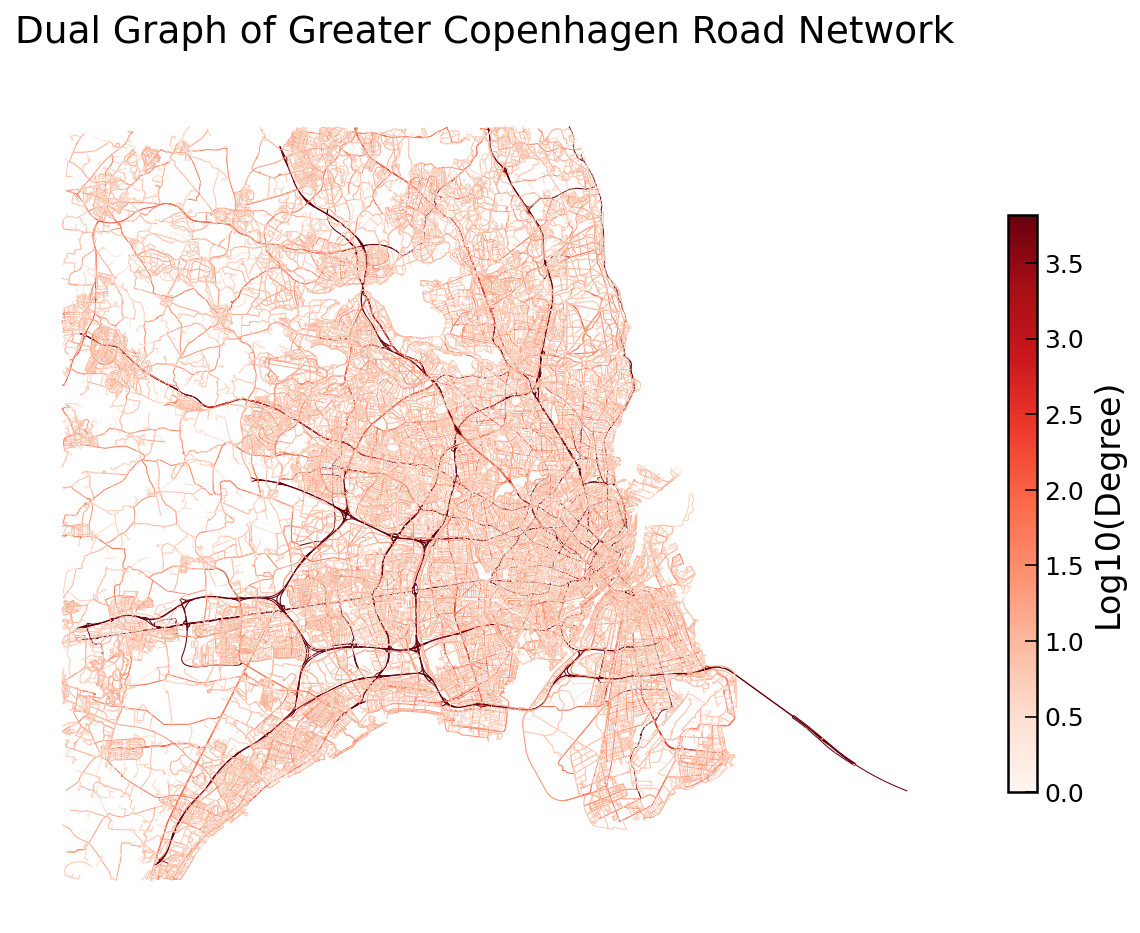

In [5]:
gdf_merged['degree_log'] = gdf_merged.degree.apply(lambda x: np.log10(x))

fig, ax = plt.subplots(figsize=(10,10))
gdf_merged.plot(column='degree_log', ax=ax, cmap='Reds', linewidth=0.5, legend=True
                , legend_kwds={'label': "Log10(Degree)", 'shrink': 0.5})
plt.title("Dual Graph of Greater Copenhagen Road Network")
plt.axis('off')
plt.show()

# Simulate

In [32]:
# project roads once
roads_proj = gdf_merged.to_crs(epsg=3857)
roads_buffered = roads_proj.geometry.buffer(5)
roads_buffered_gdf = gpd.GeoDataFrame(
    roads_proj.drop(columns='geometry'), 
    geometry=roads_buffered, 
    crs=roads_proj.crs
)

def degree_sequence(path_geom):
    # project path
    path_proj = (
        gpd.GeoSeries([path_geom], crs=4326)
        .to_crs(roads_proj.crs)
        .iloc[0]
    )

    # proportional sampling (≈1 point every X m)
    num_points = max(int(path_proj.length // 50), 2)
    distances = np.linspace(0, path_proj.length, num_points)

    # sample points
    points = [path_proj.interpolate(d) for d in distances]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=roads_proj.crs)

    # buffer points
    points_buffered = gpd.GeoDataFrame(
        geometry=points_gdf.geometry.buffer(5),
        crs=roads_proj.crs
    )

    # spatial join
    joined = gpd.sjoin(
        points_buffered,
        roads_buffered_gdf[['geometry', 'degree']],
        how='left',
        predicate='intersects'
    )

    # return clean degree sequence
    return joined['degree'].dropna().tolist()

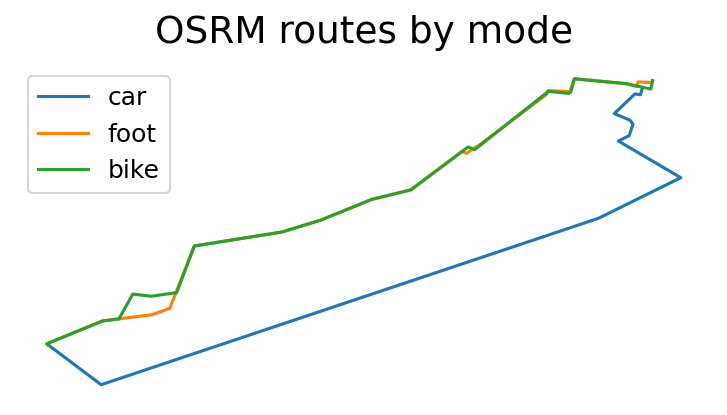

Distnaces (m):
Car: 2753.8
Foot: 2416.9
Bike: 2456.6


In [12]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)
coords = (
    gdf_merged_4326
    .sample(2)
    .geometry
    .apply(lambda g: (g.coords[0][1], g.coords[0][0]))
    .tolist()
)

coordsline_car = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="car"
)

coordsline_foot = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="foot"
)

coordsline_bike = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="bike"
)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
for r in [coordsline_car, coordsline_foot, coordsline_bike]:
    x, y = r["geometry"].xy
    ax.plot(x, y, label=r["mode"])
ax.set_aspect("equal")
ax.legend()
ax.set_title("OSRM routes by mode")
plt.axis('off')
plt.show()

print("Distnaces (m):")
print("Car:", coordsline_car["distance_m"])
print("Foot:", coordsline_foot["distance_m"])
print("Bike:", coordsline_bike["distance_m"])

In [37]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

xs_car, xs_foot, xs_bike = [], [], []
ys_car, ys_foot, ys_bike = [], [], []

N = 10_000

pairs = (
    gdf_merged_4326
    .sample(2 * N, replace=True)
    .geometry
    .apply(lambda g: g.representative_point())
    .apply(lambda p: (p.y, p.x))
    .values
    .reshape(N, 2)
    .tolist()
)

pairs = [p for p in pairs if p[0] != p[1]] # remove identical points

def run_once(coords):
    try:
        (lat1, lon1), (lat2, lon2) = coords

        car = get_osrm_route(lon1, lat1, lon2, lat2, mode="car")
        foot = get_osrm_route(lon1, lat1, lon2, lat2, mode="foot")
        bike = get_osrm_route(lon1, lat1, lon2, lat2, mode="bike")

        ds_car = degree_sequence(car["geometry"])
        ds_foot = degree_sequence(foot["geometry"])
        ds_bike = degree_sequence(bike["geometry"])

        return (
            np.arange(len(ds_car)) / len(ds_car), ds_car,
            np.arange(len(ds_foot)) / len(ds_foot), ds_foot,
            np.arange(len(ds_bike)) / len(ds_bike), ds_bike,
        )
    except Exception:
        # eg. no route found
        return None

if __name__ == "__main__":
    with Pool(cpu_count() - 2) as pool:
        for res in tqdm(pool.imap_unordered(run_once, pairs), total=len(pairs)):
            if res is None:
                continue

            xc, yc, xf, yf, xb, yb = res
            xs_car.append(xc); ys_car.append(yc)
            xs_foot.append(xf); ys_foot.append(yf)
            xs_bike.append(xb); ys_bike.append(yb)

100%|███████████████████████████████████████| 10000/10000 [14:22<00:00, 11.60it/s]


N routes: 10000


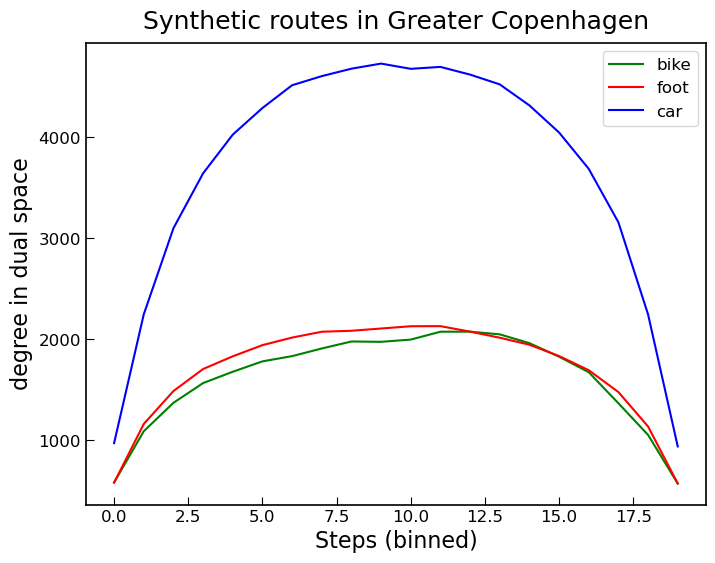

In [43]:
print("N routes:", len(xs_bike))
# plot 
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
n_bins = 20

xs_arr = np.concatenate(xs_bike)
ys_arr = np.concatenate(ys_bike)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='bike',color='green')

xs_arr = np.concatenate(xs_foot)
ys_arr = np.concatenate(ys_foot)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='foot',color='red')

xs_arr = np.concatenate(xs_car)
ys_arr = np.concatenate(ys_car)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='car',color='b')


plt.legend()
plt.ylabel('degree in dual space')
plt.xlabel('Steps (binned)')
plt.title('Synthetic routes in Greater Copenhagen')
plt.show()

In [ ]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)
distance_car, distance_foot, distance_bike = [], [], []

def run_once_distance(_):
    try:
        coords = (
            gdf_merged_4326
            .sample(2)
            .geometry
            .apply(lambda g: (g.coords[0][1], g.coords[0][0]))
            .tolist()
        )

        coordsline_car = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="car"
        )
        coordsline_foot = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="foot"
        )
        coordsline_bike = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="bike"
        )

        ds_car = coordsline_car["distance_m"]
        ds_foot = coordsline_foot["distance_m"]
        ds_bike = coordsline_bike["distance_m"]

        return (
            ds_car,
            ds_foot,
            ds_bike,
        )
    except Exception:
        return None

In [90]:
distance_car, distance_foot, distance_bike = [], [], []

for _ in tqdm(range(10_000)):
    res = run_once_distance(_)
    if res is None:
        continue
    else:
        ds_car, ds_foot, ds_bike = res
        distance_car.append(ds_car)
        distance_foot.append(ds_foot)
        distance_bike.append(ds_bike)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [04:19<00:00, 38.47it/s]


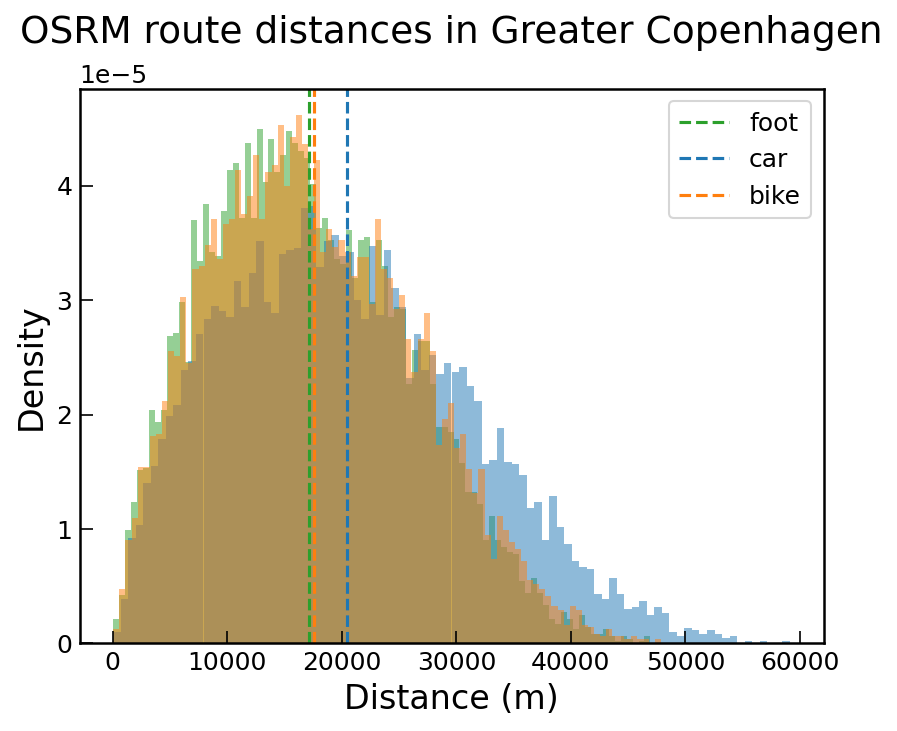

In [96]:
import numpy as np
import matplotlib.pyplot as plt

c_foot = "tab:green"
c_car  = "tab:blue"
c_bike = "tab:orange"

plt.axvline(np.mean(distance_foot), color=c_foot, linestyle="--")
plt.axvline(np.mean(distance_car),  color=c_car,  linestyle="--")
plt.axvline(np.mean(distance_bike), color=c_bike, linestyle="--")

plt.hist(distance_foot, density=True, alpha=0.5, bins=90, color=c_foot)
plt.hist(distance_car,  density=True, alpha=0.5, bins=90, color=c_car)
plt.hist(distance_bike, density=True, alpha=0.5, bins=90, color=c_bike)

plt.xlabel("Distance (m)")
plt.ylabel("Density")
plt.title("OSRM route distances in Greater Copenhagen")
plt.legend([
    "foot", "car", "bike"
])
plt.show()

# New York

In [2]:
G = ox.graph.graph_from_place("New York City, New York, USA")

In [3]:
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged.crs = 3857

osmnx graph


/home/lpsha/.conda/envs/umap-env/lib/python3.10/site-packages/momepy/preprocessing.py:771: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = CircularCompactness(gdf, area_col).series


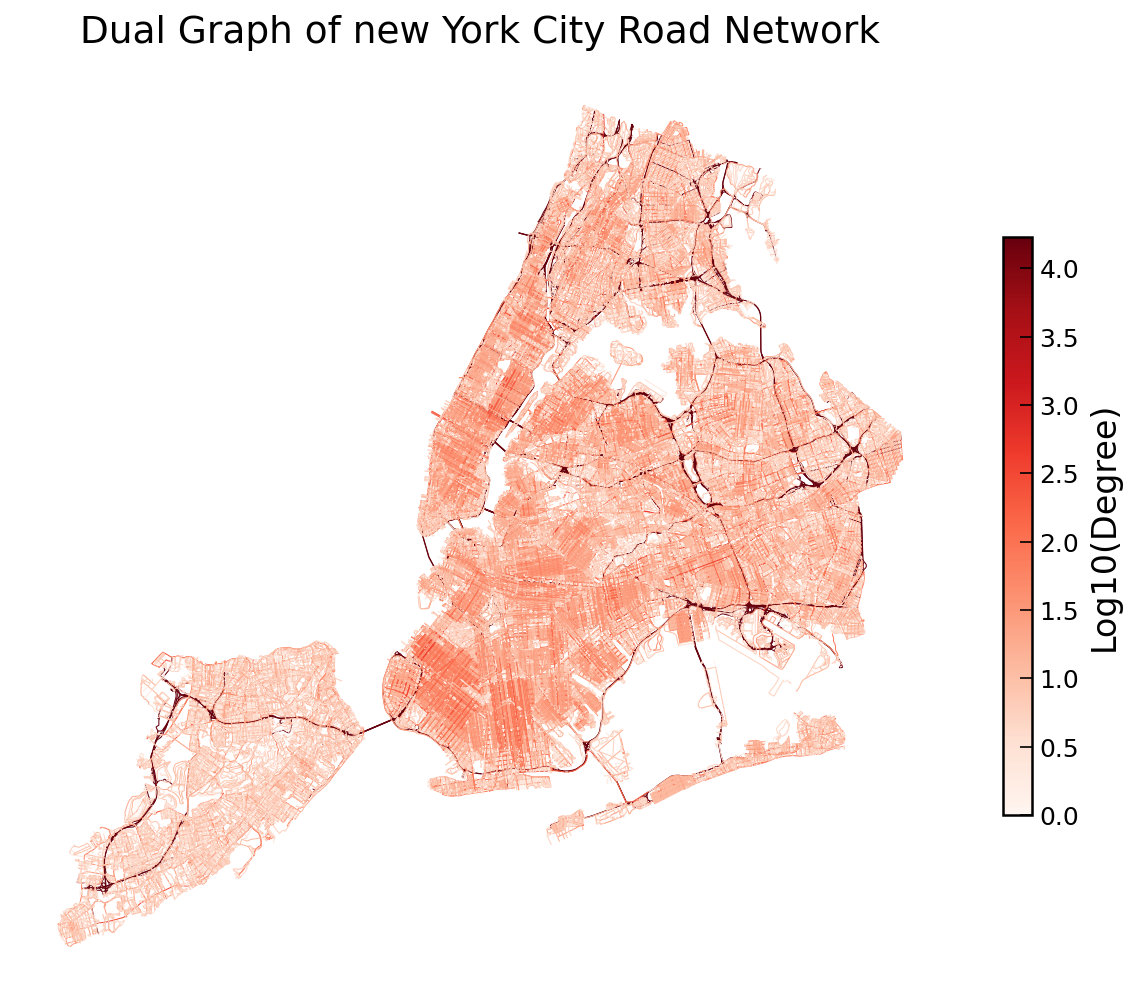

In [4]:
gdf_merged['degree_log'] = gdf_merged.degree.apply(lambda x: np.log10(x))

fig, ax = plt.subplots(figsize=(10,10))
gdf_merged.plot(column='degree_log', ax=ax, cmap='Reds', linewidth=0.5, legend=True, legend_kwds={'label': "Log10(Degree)", 'shrink': 0.5})
plt.title("Dual Graph of new York City Road Network")
plt.axis('off')
plt.show()

In [6]:
# project roads once
roads_proj = gdf_merged.to_crs(epsg=3857)
roads_buffered = roads_proj.geometry.buffer(5)
roads_buffered_gdf = gpd.GeoDataFrame(
    roads_proj.drop(columns='geometry'), 
    geometry=roads_buffered, 
    crs=roads_proj.crs
)

def degree_sequence(path_geom):
    # project path
    path_proj = (
        gpd.GeoSeries([path_geom], crs=4326)
        .to_crs(roads_proj.crs)
        .iloc[0]
    )

    # proportional sampling (≈1 point every X m)
    num_points = max(int(path_proj.length // 50), 2)
    distances = np.linspace(0, path_proj.length, num_points)

    # sample points
    points = [path_proj.interpolate(d) for d in distances]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=roads_proj.crs)

    # buffer points
    points_buffered = gpd.GeoDataFrame(
        geometry=points_gdf.geometry.buffer(5),
        crs=roads_proj.crs
    )

    # spatial join
    joined = gpd.sjoin(
        points_buffered,
        roads_buffered_gdf[['geometry', 'degree']],
        how='left',
        predicate='intersects'
    )

    # return clean degree sequence
    return joined['degree'].dropna().tolist()

In [13]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

# xs_car, xs_foot, xs_bike = [], [], []
# ys_car, ys_foot, ys_bike = [], [], []

N = 2_500

pairs = (
    gdf_merged_4326
    .sample(2 * N, replace=True)
    .geometry
    .apply(lambda g: g.representative_point())
    .apply(lambda p: (p.y, p.x))
    .values
    .reshape(N, 2)
    .tolist()
)

pairs = [p for p in pairs if p[0] != p[1]] # remove identical points

def run_once(coords):
    try:
        (lat1, lon1), (lat2, lon2) = coords

        car = get_osrm_route(lon1, lat1, lon2, lat2, mode="car")
        foot = get_osrm_route(lon1, lat1, lon2, lat2, mode="foot")
        bike = get_osrm_route(lon1, lat1, lon2, lat2, mode="bike")

        ds_car = degree_sequence(car["geometry"])
        ds_foot = degree_sequence(foot["geometry"])
        ds_bike = degree_sequence(bike["geometry"])

        return (
            np.arange(len(ds_car)) / len(ds_car), ds_car,
            np.arange(len(ds_foot)) / len(ds_foot), ds_foot,
            np.arange(len(ds_bike)) / len(ds_bike), ds_bike,
        )
    except Exception:
        # eg. no route found
        return None

if __name__ == "__main__":
    with Pool(cpu_count() - 2) as pool:
        for res in tqdm(pool.imap_unordered(run_once, pairs), total=len(pairs)):
            if res is None:
                continue

            xc, yc, xf, yf, xb, yb = res
            xs_car.append(xc); ys_car.append(yc)
            xs_foot.append(xf); ys_foot.append(yf)
            xs_bike.append(xb); ys_bike.append(yb)

100%|███████████████████████████████████████| 2500/2500 [10:41<00:00,  3.90it/s]


N routes: 7467


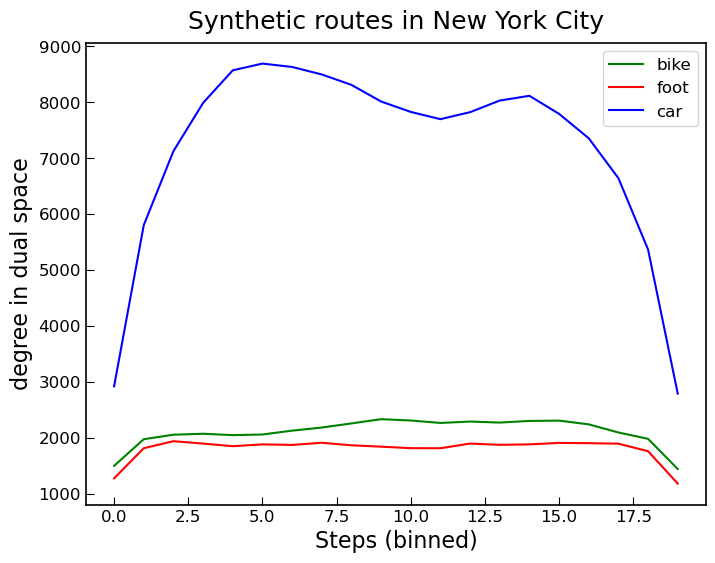

In [14]:
print("N routes:", len(xs_bike))
# plot 
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
n_bins = 20

xs_arr = np.concatenate(xs_bike)
ys_arr = np.concatenate(ys_bike)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='bike',color='green')

xs_arr = np.concatenate(xs_foot)
ys_arr = np.concatenate(ys_foot)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='foot',color='red')

xs_arr = np.concatenate(xs_car)
ys_arr = np.concatenate(ys_car)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='car',color='b')

plt.legend()
plt.ylabel('degree in dual space')
plt.xlabel('Steps (binned)')
plt.title('Synthetic routes in New York City')
plt.show()

# London

In [4]:
G = ox.graph.graph_from_place("London, England, UK")
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged.crs = 3857

osmnx graph


/home/lpsha/.conda/envs/umap-env/lib/python3.10/site-packages/momepy/preprocessing.py:771: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = CircularCompactness(gdf, area_col).series


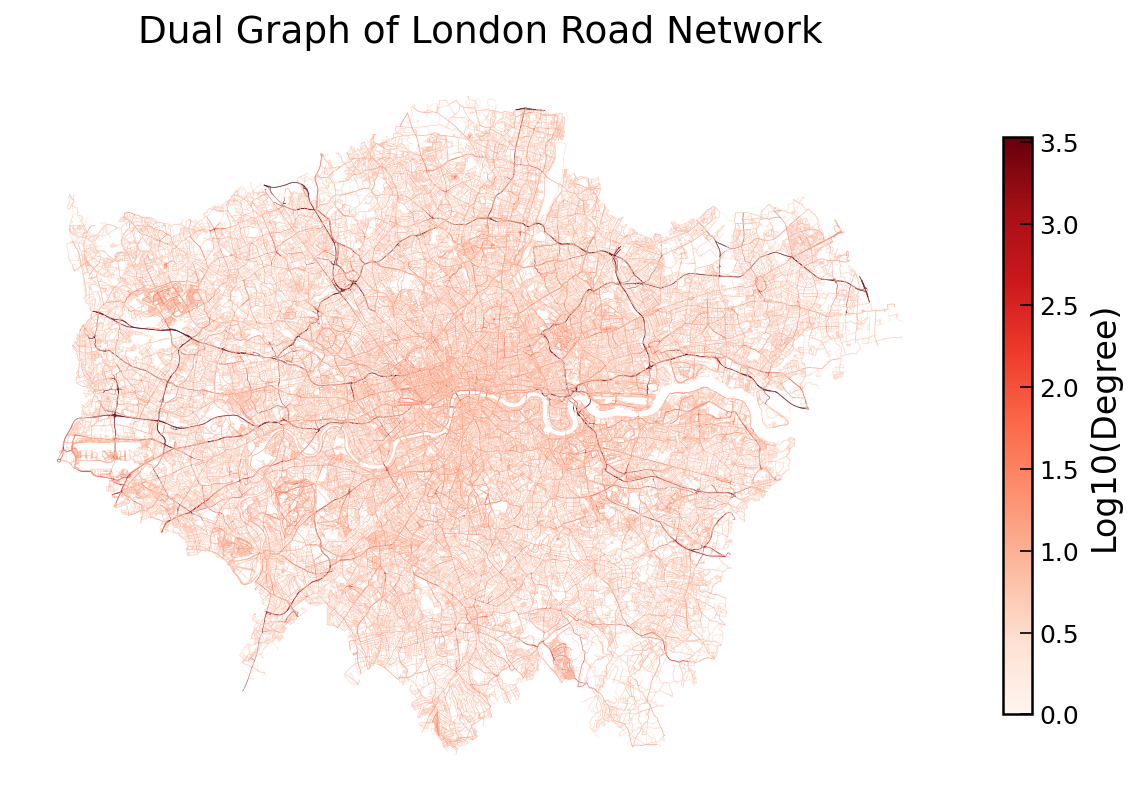

In [7]:
gdf_merged['degree_log'] = gdf_merged.degree.apply(lambda x: np.log10(x))

fig, ax = plt.subplots(figsize=(10,10))
gdf_merged.plot(column='degree_log', ax=ax, cmap='Reds', linewidth=0.3, alpha=0.7, legend=True, legend_kwds={'label': "Log10(Degree)", 'shrink': 0.5})
plt.title("Dual Graph of London Road Network")
plt.axis('off')
plt.show()

In [8]:
# project roads once
roads_proj = gdf_merged.to_crs(epsg=3857)
roads_buffered = roads_proj.geometry.buffer(5)
roads_buffered_gdf = gpd.GeoDataFrame(
    roads_proj.drop(columns='geometry'), 
    geometry=roads_buffered, 
    crs=roads_proj.crs
)

def degree_sequence(path_geom):
    # project path
    path_proj = (
        gpd.GeoSeries([path_geom], crs=4326)
        .to_crs(roads_proj.crs)
        .iloc[0]
    )

    # proportional sampling (≈1 point every X m)
    num_points = max(int(path_proj.length // 50), 2)
    distances = np.linspace(0, path_proj.length, num_points)

    # sample points
    points = [path_proj.interpolate(d) for d in distances]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=roads_proj.crs)

    # buffer points
    points_buffered = gpd.GeoDataFrame(
        geometry=points_gdf.geometry.buffer(5),
        crs=roads_proj.crs
    )

    # spatial join
    joined = gpd.sjoin(
        points_buffered,
        roads_buffered_gdf[['geometry', 'degree']],
        how='left',
        predicate='intersects'
    )

    # return clean degree sequence
    return joined['degree'].dropna().tolist()

In [12]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

xs_car, xs_foot, xs_bike = [], [], []
ys_car, ys_foot, ys_bike = [], [], []

N = 5_000

pairs = (
    gdf_merged_4326
    .sample(2 * N, replace=True)
    .geometry
    .apply(lambda g: g.representative_point())
    .apply(lambda p: (p.y, p.x))
    .values
    .reshape(N, 2)
    .tolist()
)

pairs = [p for p in pairs if p[0] != p[1]] # remove identical points

def run_once(coords):
    try:
        (lat1, lon1), (lat2, lon2) = coords

        car = get_osrm_route(lon1, lat1, lon2, lat2, mode="car")
        foot = get_osrm_route(lon1, lat1, lon2, lat2, mode="foot")
        bike = get_osrm_route(lon1, lat1, lon2, lat2, mode="bike")

        ds_car = degree_sequence(car["geometry"])
        ds_foot = degree_sequence(foot["geometry"])
        ds_bike = degree_sequence(bike["geometry"])

        return (
            np.arange(len(ds_car)) / len(ds_car), ds_car,
            np.arange(len(ds_foot)) / len(ds_foot), ds_foot,
            np.arange(len(ds_bike)) / len(ds_bike), ds_bike,
        )
    except Exception:
        # eg. no route found
        return None

if __name__ == "__main__":
    with Pool(cpu_count() - 2) as pool:
        for res in tqdm(pool.imap_unordered(run_once, pairs), total=len(pairs)):
            if res is None:
                continue

            xc, yc, xf, yf, xb, yb = res
            xs_car.append(xc); ys_car.append(yc)
            xs_foot.append(xf); ys_foot.append(yf)
            xs_bike.append(xb); ys_bike.append(yb)

100%|█████████████████████████████████████████| 5000/5000 [04:34<00:00, 18.21it/s]


N routes: 9953


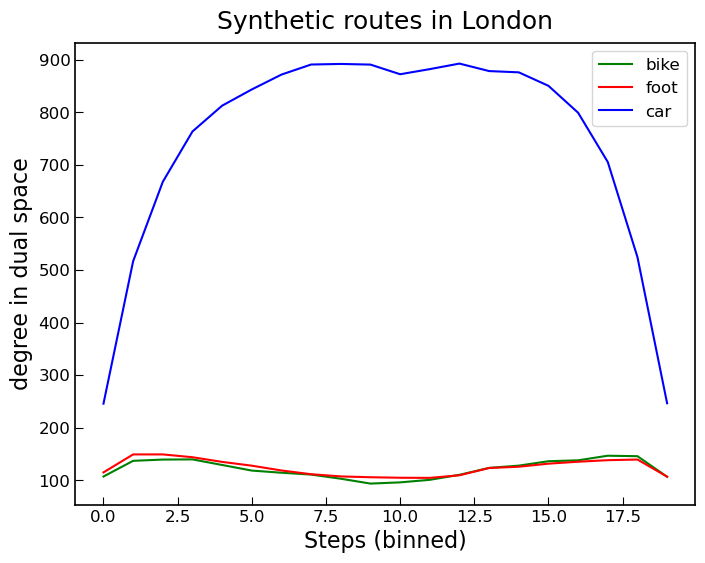

In [13]:
print("N routes:", len(xs_bike))
# plot 
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
n_bins = 20

xs_arr = np.concatenate(xs_bike)
ys_arr = np.concatenate(ys_bike)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='bike',color='green')

xs_arr = np.concatenate(xs_foot)
ys_arr = np.concatenate(ys_foot)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='foot',color='red')

xs_arr = np.concatenate(xs_car)
ys_arr = np.concatenate(ys_car)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='car',color='b')


plt.legend()
plt.ylabel('degree in dual space')
plt.xlabel('Steps (binned)')
plt.title('Synthetic routes in London')
plt.show()

In [14]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

xs_car, xs_foot, xs_bike = [], [], []
ys_car, ys_foot, ys_bike = [], [], []

N = 1_000

pairs = (
    gdf_merged_4326
    .sample(2 * N, replace=True)
    .geometry
    .apply(lambda g: g.representative_point())
    .apply(lambda p: (p.y, p.x))
    .values
    .reshape(N, 2)
    .tolist()
)

pairs = [p for p in pairs if p[0] != p[1]] # remove identical points

def run_once(coords):
    try:
        (lat1, lon1), (lat2, lon2) = coords

        car = get_osrm_route(lon1, lat1, lon2, lat2, mode="car")
        foot = get_osrm_route(lon1, lat1, lon2, lat2, mode="foot")
        bike = get_osrm_route(lon1, lat1, lon2, lat2, mode="bike")

        ds_car = degree_sequence(car["geometry"])
        ds_foot = degree_sequence(foot["geometry"])
        ds_bike = degree_sequence(bike["geometry"])

        return (
            car['distance_m'], ds_car,
            foot['distance_m'], ds_foot,
            bike['distance_m'], ds_bike,
        )
    except Exception:
        # eg. no route found
        return None

if __name__ == "__main__":
    with Pool(cpu_count() - 2) as pool:
        for res in tqdm(pool.imap_unordered(run_once, pairs), total=len(pairs)):
            if res is None:
                continue

            xc, yc, xf, yf, xb, yb = res
            xs_car.append(xc); ys_car.append(yc)
            xs_foot.append(xf); ys_foot.append(yf)
            xs_bike.append(xb); ys_bike.append(yb)

100%|█████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.15it/s]


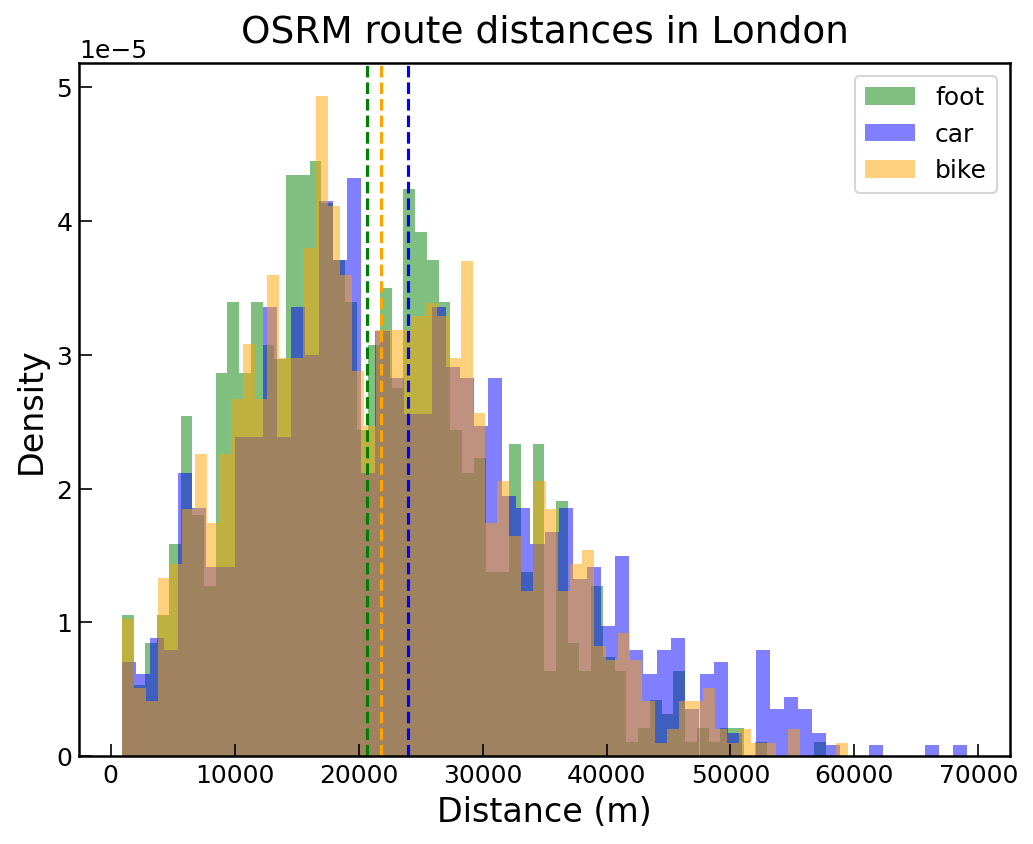

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(xs_foot, density=True, alpha=0.5, bins=60, color='green', label='foot')
ax.hist(xs_car,  density=True, alpha=0.5, bins=60, color='blue', label='car')
ax.hist(xs_bike, density=True, alpha=0.5, bins=60, color='orange', label='bike')

# mean distance lines
plt.axvline(np.mean(xs_foot), color='green', linestyle="--")
plt.axvline(np.mean(xs_car),  color='blue',  linestyle="--")
plt.axvline(np.mean(xs_bike), color='orange', linestyle="--")

plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Density")
plt.title("OSRM route distances in London")
plt.show()